### Experiments to demonstrate that weights evolve via D2 given signal and no noise 
A (0-layer) neural network that uses a smooth nonlinear activation like tanh and trains its weights using backpropagation will cause weights to shift by D2(z) := tanh(z)*(d/dt tanh(z)). For this analysis, we substitute changing weights with changing weights-divided-by-x-value, leaving us with only the composites.

Section 1:
- For each nonlinearity of interest, 
 - For each target value y_i,
   - For each v_i in a region of interest,
     - Compute and display the error-signal-based gradient update that a v_i would have received.

In [1]:
%matplotlib inline
# ^ enables usage of matplotlib and furthermore enables displaying it in the notebook

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-f043txkk because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

Manually create D2 and D4 of functions:

In [32]:
def tanh(x): return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
def d2_tanh(x,y=0): return -(y-tanh(x))*(1-tanh(x)**2) 
def sech(x): return 2/(np.exp(x)+np.exp(-x))
def d4_tanh(x,y=0): return -2*sech(x)**2*tanh(x) - 6*sech(x)**4*tanh(x) + 6*sech(x)**2*tanh(x)**3
# ^ -2 sech^4(x) (y - 3 tanh(x)) + 2 sech^2(x) tanh(x) (1 + 2 y tanh(x) - 3 tanh^2(x))


Plotters convenience function:

In [248]:
def Plot(f, vals=V_values, color=None): 
    if color==None: plt.plot(vals, [f(v) for v in vals])
    else: plt.plot(vals, [f(v) for v in vals], color=color)
def PlotAxes(xbounds=[-1,1], ybounds=[-1,1], color=[0,0,0,0.3]):
    plt.plot([0,0], ybounds, '--', color=color)
    plt.plot(xbounds, [0,0], '--', color=color)

Sanity check; plot tanh, its D2, its D4

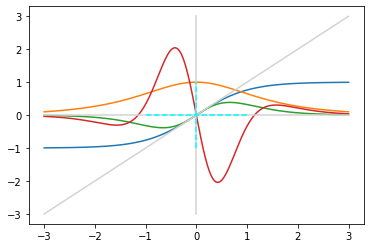

In [251]:
V_values = np.linspace(-3,3,100*(3--3)+1)

Plot(tanh)
Plot(sech)
Plot(d2_tanh)
Plot(d4_tanh)
Plot(lambda x:0, color='lightgray')
Plot(lambda x:x, color='lightgray')
plt.plot([0,0],[-3,3], color='lightgray')
#PlotAxes([-1,1],[-1,1],'cyan')

start of Section 1. First, delimit parameters; concurrently, initialize network;

In [236]:
# delimit parameters
Nonlinearities = [ ('tanh',tanh) ]                  # s_counter
# Y_values = [0,-1,1]                                 # y_counter
Y_values = list(np.linspace(-1,1,9))
V_values = np.linspace(-3,3,100*(3--3)+1)           # v_counter
# V_values = np.linspace(-3,3,14)           # dev
X_data = [ np.ones(v.shape) for v in V_values ]     # x_counter

learning_rate=1e0
V_values[:1], V_values.shape

(array([-3.]), (601,))

In [ ]:
def Set_weights(layer, weights):
    layer.set_weights([np.expand_dims(weights,0).T])
    
# initialize a network whose weights we manually set
def init_manual_model(nonlinearity, weight_value, learning_rate=0.01):
    nonlinearity_name, nonlinearity_function=nonlinearity
    model = Sequential()
    model.add(
        Dense(
            1, # num output units
            kernel_initializer=tf.keras.initializers.zeros(),   #  placeholder
            input_shape=(1,),
            activation=nonlinearity_name,
            use_bias=False,
        )
    )
    model.compile(
        loss=tf.keras.losses.mean_squared_error,
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
    )
    Set_weights(model.layers[0], weight_value)
    return model
test_model_init=init_manual_model(Nonlinearities[0], V_values[:1])
# [l.get_config() for l in test_model_init.layers]


In [237]:
def query_manual_model():
    dev_model=init_manual_model(Nonlinearities[0], np.zeros((1,))) # tmp: only combo
    weights_inbox = []
    changes_inbox = []
    weights_to_changes = []  # tuple of indices counter-coords then data (weight, change)
    weights_to_changes_tensor = np.empty( (len(Y_values), 1, len(Nonlinearities), V_values.shape[0], 2 ) )

    # counters. vi: different values of vi
    
    
    for y_counter in range(len(Y_values)):
#      for x_counter in range(len(X_data)):
     for x_counter in range(1):
      for s_counter in range(len(Nonlinearities)):
       for v_counter in range(V_values.shape[0]):
        tensor_coords = (y_counter, x_counter, s_counter, v_counter)
        Set_weights(dev_model.layers[0], V_values[v_counter:v_counter+1])
        
        weights_retreiver = LambdaCallback( \
                on_epoch_begin=lambda batch, logs: weights_inbox.append( dev_model.layers[0].get_weights()[0]))
        changes_retriever = LambdaCallback( 
                on_epoch_end  =lambda batch, logs: changes_inbox.append( dev_model.layers[0].get_weights()[0]))        
        dev_model.fit(
            np.array([ X_data[0] ]),     # one datapoint for now   x_counter
            np.array([ Y_values[y_counter] ]),   # one datapoint for now.  y_counter
            batch_size=1,
            epochs=1,
            callbacks=[weights_retreiver, changes_retriever], 
            verbose=0
        )
        change = changes_inbox[-1]-weights_inbox[-1]
        weights_to_changes.append( (weights_inbox[-1][0][0], change[0][0]) )
        weights_to_changes_tensor[y_counter, x_counter, s_counter, v_counter, :] = np.array([weights_inbox[-1][0][0], change[0][0]])
        if (v_counter % int(V_values.shape[0]//10) == 0 and V_values.shape[0]>100) or v_counter==V_values.shape[0]-1:
            print('iteration '+str(v_counter)+'/'+str(V_values.shape[0])+' done; '+str(tensor_coords))

#     print(weights_inbox)
#     print()
#     print(changes_inbox)
#     print()
#     print(weights_to_changes)
    print('done')
    return weights_to_changes, weights_to_changes_tensor

wtc,wtct=query_manual_model()

iteration 0/601 done; (0, 0, 0, 0)
iteration 60/601 done; (0, 0, 0, 60)
iteration 120/601 done; (0, 0, 0, 120)
iteration 180/601 done; (0, 0, 0, 180)
iteration 240/601 done; (0, 0, 0, 240)
iteration 300/601 done; (0, 0, 0, 300)
iteration 360/601 done; (0, 0, 0, 360)
iteration 420/601 done; (0, 0, 0, 420)
iteration 480/601 done; (0, 0, 0, 480)
iteration 540/601 done; (0, 0, 0, 540)
iteration 600/601 done; (0, 0, 0, 600)
iteration 0/601 done; (1, 0, 0, 0)
iteration 60/601 done; (1, 0, 0, 60)
iteration 120/601 done; (1, 0, 0, 120)
iteration 180/601 done; (1, 0, 0, 180)
iteration 240/601 done; (1, 0, 0, 240)
iteration 300/601 done; (1, 0, 0, 300)
iteration 360/601 done; (1, 0, 0, 360)
iteration 420/601 done; (1, 0, 0, 420)
iteration 480/601 done; (1, 0, 0, 480)
iteration 540/601 done; (1, 0, 0, 540)
iteration 600/601 done; (1, 0, 0, 600)
iteration 0/601 done; (2, 0, 0, 0)
iteration 60/601 done; (2, 0, 0, 60)
iteration 120/601 done; (2, 0, 0, 120)
iteration 180/601 done; (2, 0, 0, 180)
iter

In [299]:
#wtct[:,:,:,297:303,:]
len(wtc)/9, len(wtc)%9,V_values.shape
len(V_values)

601

In [326]:
150*np.max(wtct[:,:,:,:,1])#, key=lambda x:x[1])[1]


3.5555005073547363

(0.3500000000000001, 1.1851666469338036) (0.35, -0.023703337)
(0.3999999999999999, 0.9668281583977472) (0.4, -0.019336551)
(0.4700000000000002, 0.7580475588000706) (0.47, -0.015160948)
(0.5500000000000003, 0.5624995262747763) (0.55, -0.011250019)
(-0.6600000000000001, -0.38489840053811114) (-0.66, 0.00769794)
(-0.5499999999999998, -0.5624995262747763) (-0.55, 0.011250019)
(-0.46999999999999975, -0.7580475588000707) (-0.47, 0.015160948)
(-0.3999999999999999, -0.9668281583977472) (-0.4, 0.019336551)
(-0.3500000000000001, -1.1851666469338036) (-0.35, 0.023703337)
07_13-06_02_32


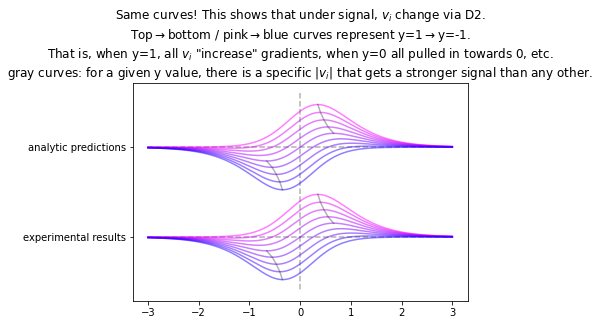

In [370]:
shift_ = 2.5
scale_ = 50
# shift_ = min(wtc, key=lambda x:x[1])[1] * 2.1 * scale_

# plot axes
plt.plot([0,0], [1.5,-shift_-1.5], '--', color=[0,0,0,0.3])
plt.plot([-3,3], [0,0], '--', color=[0,0,0,0.3])
plt.plot([-3,3], [-shift_, -shift_], '--', color=[0,0,0,0.3])
plt.yticks([-shift_,0], ['experimental results','analytic predictions'])

extrema1, extrema2=[],[]
for yval_itr, y_val in enumerate(Y_values):
    # plot analytic results
    Plot(lambda x:d2_tanh(x,y_val), color=[1.-yval_itr/len(Y_values),0,1,0.5])
    extremum1=max([(vi,d2_tanh(vi,y_val)) for vi in V_values], key=lambda x:abs(x[1]))
    extrema1.append(extremum1)
    if y_val==0: 
        extrema1.append((-extremum1[0], -extremum1[1]))
    
    # plot experimental results
    single_out_curve=wtc[yval_itr*V_values.shape[0]:(yval_itr+1)*V_values.shape[0]]
    plt.plot([w[0] for w in single_out_curve], 
             [-scale_*w[1]-shift_ for w in single_out_curve],
             color=[1.-yval_itr/len(Y_values),0,1,0.5])
    extremum2=max(single_out_curve, key=lambda x:abs(x[1]))
    #print(single_out_curve[:3], extremum_vi)# single_out_curve[extremum_vi[0]-1:extremum_vi[0]+1])
    print(extremum1, extremum2)
    extrema2.append((extremum2[0], -extremum2[1]*scale_-shift_))
    if y_val==0: 
        extrema2.append((-extremum2[0], extremum2[1]*scale_-shift_))

Len=len(extrema1)
plt.plot([e[0] for e in extrema1 if e[0]<0],[e[1] for e in extrema1 if e[0]<0], color=[0,0,0,.3])
plt.plot([e[0] for e in extrema1 if e[0]>0],[e[1] for e in extrema1 if e[0]>0], color=[0,0,0,.3])
plt.plot([e[0] for e in extrema2 if e[0]<0],[e[1] for e in extrema2 if e[0]<0], color=[0,0,0,.3])
plt.plot([e[0] for e in extrema2 if e[0]>0],[e[1] for e in extrema2 if e[0]>0], color=[0,0,0,.3])
    
plt.title(r'Same curves! This shows that under signal, $v_i$ change via D2.'+'\n'+
          r'Top$\rightarrow$bottom / pink$\rightarrow$blue curves represent y=1$\rightarrow$y=-1.'+'\n'+
          r'That is, when y=1, all $v_i$ "increase" gradients, when y=0 all pulled in towards 0, etc.'+'\n'+
          r'gray curves: for a given y value, there is a specific $|v_i|$ that gets a stronger signal than any other.')

if 0:
    savefig_utf_timestamp=dt.now().strftime('%m_%d-%H_%M_%S')
    print(savefig_utf_timestamp)
    plt.savefig('figures/fig_'+savefig_utf_timestamp+'.pdf', bbox_inches='tight')
if 0:   
    plt.show()

[[0.66       0.3848984 ]
 [0.56       0.56249953]
 [0.47       0.75804756]
 [0.4        0.96682816]
 [0.35       1.18516665]]


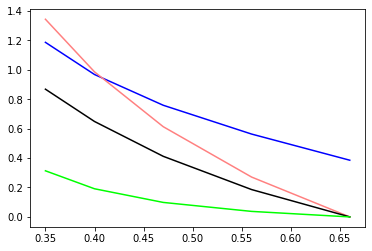

In [419]:
some_data=np.array([(-0.66, -0.38489840053811114) ,
(-0.56, -0.5624995262747763) ,
(-0.47, -0.7580475588000707) ,
(-0.4,  -0.9668281583977472) ,
(-0.35, -1.1851666469338036) ])*-1
some_data[:,0],some_data[:,1]
some_data[:,1]=some_data[:,1]
# some_data[:,0]-=min(some_data[:,0])
# some_data[:,0]/=max(some_data[:,0])
# some_data[:,1]-=min(some_data[:,1])
# some_data[:,1]/=max(some_data[:,1])
print(some_data)
plt.plot(some_data[:,0],some_data[:,1], color='blue')
# plt.plot(some_data[:,0],1/some_data[:,0]**2, color=[1,0,1])
plt.plot(some_data[:,0],1/some_data[:,0]**1  - min(1/some_data[:,0]**1), color=[1,.5,.5])
#plt.plot(some_data[:,0],1/some_data[:,0]**.5, color=[1,1,0])
plt.plot(some_data[:,0],1/some_data[:,0]**0.77 - min(1/some_data[:,0]**0.77), color=[0,0,0])
plt.plot(some_data[:,0][::-1],some_data[:,0]**2 - min(some_data[:,0]**2), color=[0,1,0])


In [333]:
help(plt.savefig)

Help on function savefig in module matplotlib.pyplot:

savefig(*args, **kwargs)
    Save the current figure.
    
    Call signature::
    
      savefig(fname, *, dpi='figure', format=None, metadata=None,
              bbox_inches=None, pad_inches=0.1,
              facecolor='auto', edgecolor='auto',
              backend=None, **kwargs
             )
    
    The available output formats depend on the backend being used.
    
    Parameters
    ----------
    fname : str or path-like or binary file-like
        A path, or a Python file-like object, or
        possibly some backend-dependent object such as
        `matplotlib.backends.backend_pdf.PdfPages`.
    
        If *format* is set, it determines the output format, and the file
        is saved as *fname*.  Note that *fname* is used verbatim, and there
        is no attempt to make the extension, if any, of *fname* match
        *format*, and no extension is appended.
    
        If *format* is not set, then the format is inf

(9, 1, 1, 601) (9, 1, 1, 601, 2)


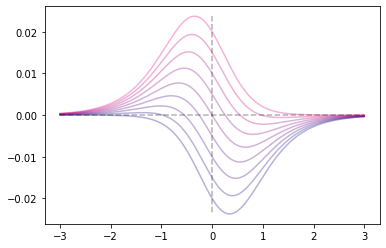

In [306]:
coords_bounds=len(Y_values), 1, len(Nonlinearities), V_values.shape[0]
print(coords_bounds, wtct.shape)
for y_counter in range(len(Y_values)):
#for x_counter in range(len(X_data)):
 for x_counter in range(1):
  for s_counter in range(len(Nonlinearities)):
#    for v_counter in range(V_values.shape[0]):
    for v_counter in range(1):
        tensor_coords = (yc,xc,sc,vc) = (y_counter, x_counter, s_counter, v_counter)
        percent_coords =pc= (y_counter/len(Y_values),
                          x_counter/len(X_data),
                          s_counter/len(Nonlinearities),
                          v_counter/V_values.shape[0] )
        #print(percent_coords)
        plt.plot(wtct[yc,xc,sc,:,0], wtct[yc,xc,sc,:,1], color=[percent_coords[0],0,0.5,0.3])
PlotAxes([-3,3], [np.max(wtct[:,:,:,:,1]), np.min(wtct[:,:,:,:,1])])


In [113]:
x = np.array([1,2,3])
x=np.expand_dims(x,axis=0)
x.shape
# //
# sorted(dev_model.layers[0].__dir__())   prints
dev_model.layers[0].get_weights()
help(dev_model.fit)

[array([[-3.],
        [-2.],
        [-1.],
        [ 0.],
        [ 1.],
        [ 2.],
        [ 3.]], dtype=float32)]

In [67]:
#tf.keras.initializers.__dir__()
# help(tf.keras.initializers.zeros)
help(tf.optimizers.SGD)

Help on class SGD in module keras.optimizer_v2.gradient_descent:

class SGD(keras.optimizer_v2.optimizer_v2.OptimizerV2)
 |  SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD', **kwargs)
 |  
 |  Gradient descent (with momentum) optimizer.
 |  
 |  Update rule for parameter `w` with gradient `g` when `momentum` is 0:
 |  
 |  ```python
 |  w = w - learning_rate * g
 |  ```
 |  
 |  Update rule when `momentum` is larger than 0:
 |  
 |  ```python
 |  velocity = momentum * velocity - learning_rate * g
 |  w = w + velocity
 |  ```
 |  
 |  When `nesterov=True`, this rule becomes:
 |  
 |  ```python
 |  velocity = momentum * velocity - learning_rate * g
 |  w = w + momentum * velocity - learning_rate * g
 |  ```
 |  
 |  Args:
 |    learning_rate: A `Tensor`, floating point value, or a schedule that is a
 |      `tf.keras.optimizers.schedules.LearningRateSchedule`, or a callable
 |      that takes no arguments and returns the actual value to use. The
 |      learning rate. De

In [330]:
def save_fig():
    savefig_utf_timestamp=dt.now().strftime('%m_%d-%H_%M_%S')
    print(savefig_utf_timestamp)
    plt.savefig('figures/fig_'+savefig_utf_timestamp)
#plt.show()